In [1]:
#autoencoder로 망가진 이미지 복원하기
#잡음제거 오토인코더(denoising autoencoder)
import torch
import torchvision
import torch.nn.functional as F
from torch import nn,optim
from torchvision import transforms,datasets

In [2]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import numpy as np

In [3]:
#hyper parameter 
EPOCH = 10 
BATCH_SIZE = 64
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device('cuda' if USE_CUDA else 'cpu')
print('using_device',DEVICE)

using_device cpu


In [4]:
#Fmnist dataset loading
trainset = datasets.FashionMNIST(
    root= './.data/',
    train = True,
    download= True,
    transform= transforms.ToTensor()
)
train_loader = torch.utils.data.DataLoader(
    dataset = trainset,
    batch_size = BATCH_SIZE,
    shuffle = True,
    num_workers = 2
)

In [5]:
#autoencoder module define
#오토인코더에는 encoder부분과 decoder부분이 있음 이를 nn.Sequential를 이용하여 묶어줄 것임
#nn.Sequential는 여러 모듈을 하나로 묶을 수 있음, 코드를 간결하게 만들수있고 계층과 활성화함수를 정의해주면 순서대로 값을 전달해 처리함
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder,self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28*28,128),
            nn.ReLU(),
            nn.Linear(128,64),
            nn.ReLU(),
            nn.Linear(64,12),
            nn.ReLU(),
            nn.Linear(12,3),#마지막 3차원에서 시각화할 수 있도록 feature를 3개만 남김
        )
        self.decoder = nn.Sequential(
            nn.Linear(3,12),
            nn.ReLU(),
            nn.Linear(12,64),
            nn.ReLU(),
            nn.Linear(64,128),
            nn.ReLU(),
            nn.Linear(128,28*28),
            nn.Sigmoid(),
        )
    def forward(self,x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

    

In [6]:
autoencoder = Autoencoder().to(DEVICE)
optimizer = torch.optim.Adam(autoencoder.parameters(),lr = 0.005)
criterion = nn.MSELoss()

In [7]:
#원본 이미지 시각화하기
view_data = trainset.data[:5].view(-1,28*28)
view_data = view_data.type(torch.FloatTensor)/255. # 255로 나누는 이유는 픽셀의 색상값이 0-255이고 0과 1 사이의 값으로 만들어야지
#모델이 인식하기 때문이다.

In [8]:
############# add noise !
#학습 시 모델에 들어갈 입력에 add_noise함수를 더해 이미지에 무작위 잡음을 더한다. 무작위 잡음은 torch.randn으로 만들고
#입력에 이미지의 크기를 넣어서 이미지와 같은 크기의 잡음을 만들고 이미지와 더해주면 된다. 
# 잡음의 강도는 임의로 설정 가능 여기서는 0.2
def add_noise(img):
    noise = torch.randn(img.size())*0.2
    noisy_img = img + noise
    return noisy_img

In [9]:
def train(autoencoder,train_loader):
    autoencoder.train()
    avg_loss = 0 #변화하는 오차를 확인하기 위하여 생성함
    for step, (x,label) in enumerate(train_loader):
        x = add_noise(x) # 입력에 노이즈 더하기
        x = x.view(-1,28*28).to(DEVICE)
        y = x.view(-1,28*28).to(DEVICE)
        label = label.to(DEVICE)
        
        encoded, decoded = autoencoder(x)
        
        loss = criterion(decoded,y) 
        optimizer.zero_grad()#함수에 있을수도 있는 grad초기화
        loss.backward()#backward 로 기울기를 구함
        optimizer.step()#step으로 최적화 진행
        avg_loss += loss.item()
    return avg_loss / len(train_loader)

In [10]:
for epoch in range(1,EPOCH+1):
    loss = train(autoencoder,train_loader)
    print('epoch{},loss{}'.format(epoch,loss))

epoch1,loss0.08880551965601409
epoch2,loss0.06802989345496652
epoch3,loss0.06505142871155413
epoch4,loss0.06411484098320068
epoch5,loss0.06350174564510774
epoch6,loss0.06318728829513608
epoch7,loss0.0628919660655865
epoch8,loss0.06286992484540828
epoch9,loss0.06255671988402221
epoch10,loss0.06252246210649451


In [11]:
# 잡음 제거 시각화하기
# 모델이 본 적 없는 테스트 이미지를 활용해 검증해보자
testset = datasets.FashionMNIST(
            root = './.data/',
            train = False,
            download = True,
            transform = transforms.ToTensor())

In [12]:
sample_data = testset.data[0].view(-1,28*28) # 테스트셋에서 첫번째 이미지를 가져와서 모델의 입력으로 사용
sample_data = sample_data.type(torch.FloatTensor)/255.

original_x = sample_data[0]
noisy_x = add_noise(original_x).to(DEVICE)
_,recovered_x = autoencoder(noisy_x) # _의 의미는 특정값을 무시하는 변수, 즉 사용하지 않으니까 쓰는 것

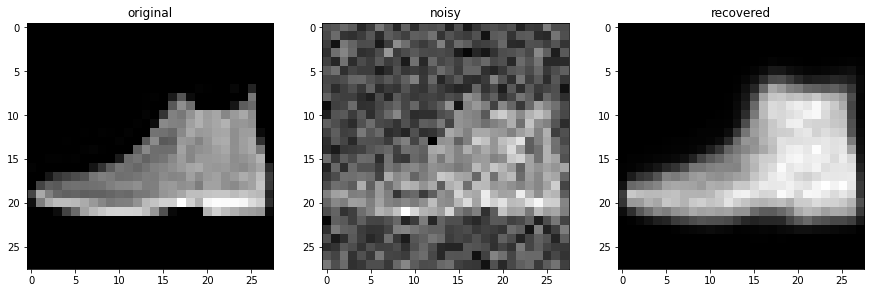

In [13]:
f,a = plt.subplots(1,3,figsize = (15,15))
original_img = np.reshape(original_x.to('cpu').data.numpy(),(28,28))
noisy_img = np.reshape(noisy_x.to('cpu').data.numpy(),(28,28))
recovered_img = np.reshape(recovered_x.to('cpu').data.numpy(),(28,28))

#원본 사진
a[0].set_title('original')
a[0].imshow(original_img,cmap='gray')
#오염
a[1].set_title('noisy')
a[1].imshow(noisy_img,cmap='gray')
#복원
a[2].set_title('recovered')
a[2].imshow(recovered_img,cmap='gray')

plt.show()

In [ ]:
#이를 통하여 오토인코더가 중요한 feature만 남기고 우선순위가 아닌 것을 제거하는 방식으로 이미지를 압축, 복원한다는 것을 배울 수 있다.